## Model - Time Series Analysis

In [29]:
import pandas as pd
df = pd.read_csv("data/preprocessed/ts_data_15min.csv")
df

,dateTime,bikesInUsage,electricalBikesInUsage,mechanicalBikesInUsage
0,2018-08-01 00:00:00,NaN,NaN,NaN
1,2018-08-01 00:15:00,NaN,NaN,NaN
2,2018-08-01 00:30:00,NaN,NaN,NaN
3,2018-08-01 00:45:00,NaN,NaN,NaN
4,2018-08-01 01:00:00,NaN,NaN,NaN
...,...,...,...,...
22747,2019-03-25 22:45:00,NaN,NaN,NaN
22748,2019-03-25 23:00:00,NaN,NaN,NaN
22749,2019-03-25 23:15:00,NaN,NaN,NaN
22750,2019-03-25 23:30:00,NaN,NaN,NaN


In [30]:
print(df.columns.tolist())

['dateTime', 'bikesInUsage', 'electricalBikesInUsage', 'mechanicalBikesInUsage']


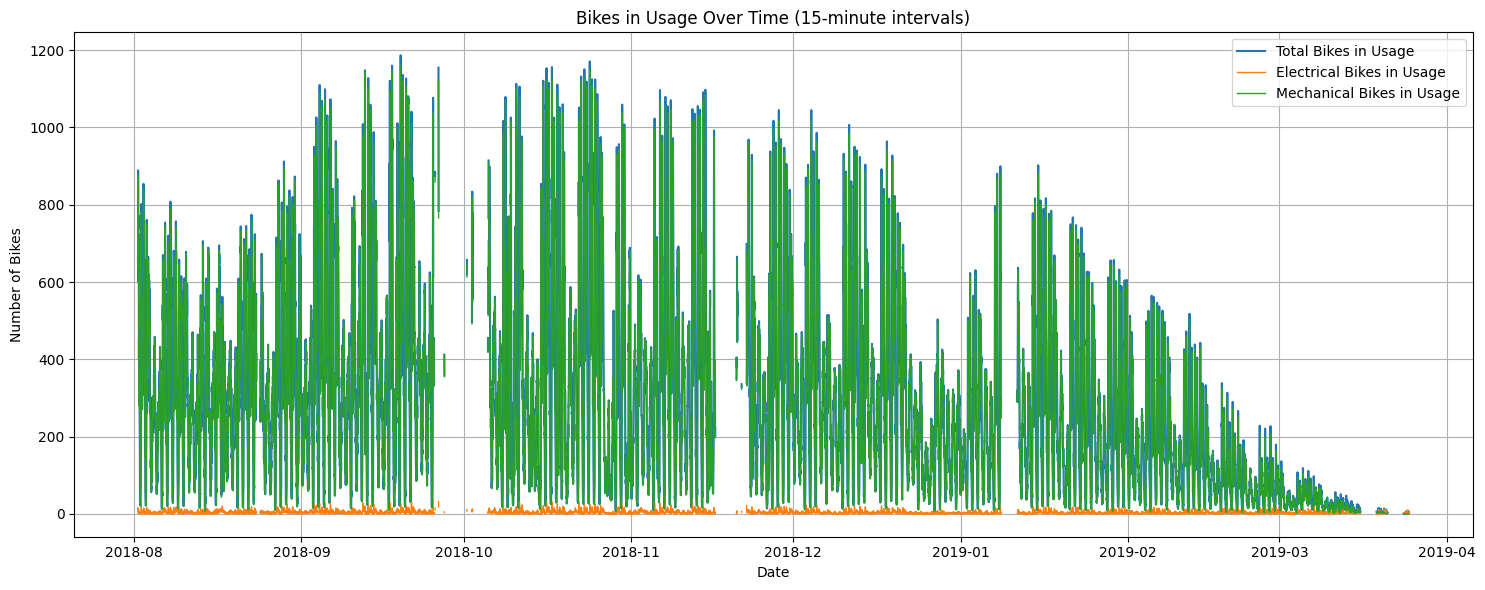

In [31]:
import matplotlib.pyplot as plt

# Convert dateTime to datetime
df["dateTime"] = pd.to_datetime(df["dateTime"])

# Set datetime as index
df.set_index("dateTime", inplace=True)

# Plot each time series with NaNs naturally omitted
plt.figure(figsize=(15, 6))
plt.plot(df.index, df["bikesInUsage"], label="Total Bikes in Usage", linewidth=1.5)
plt.plot(df.index, df["electricalBikesInUsage"], label="Electrical Bikes in Usage", linewidth=1)
plt.plot(df.index, df["mechanicalBikesInUsage"], label="Mechanical Bikes in Usage", linewidth=1)

plt.title("Bikes in Usage Over Time (15-minute intervals)")
plt.xlabel("Date")
plt.ylabel("Number of Bikes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As observed in the time series plot, bike usage in Barcelona follows a clear cyclical pattern from **August 2018 through early 2019**. However, starting in **February–March 2019**, the data shows a sharp decline in usage.

This is a problem because:

- The final months **break the seasonality and trend** that the model needs to learn.
- These periods are likely affected by **external disruptions** (e.g., system shutdown, incomplete data collection, or transition to a new platform).
- **Imputation becomes unreliable**; we end up filling large gaps with averages from much earlier periods, leading to unrealistic spikes.
- Most ML models assume some degree of **stationarity** (stable patterns); this breakdown violates that assumption.

Thus, we decided to restrict our dataset to the **stable, high-quality segment** of the time series, from the beginning until usage starts to collapse.

In [32]:
cutoff = "2019-02-01"
df = df.loc[:cutoff]
df

,bikesInUsage,electricalBikesInUsage,mechanicalBikesInUsage
dateTime,,,
2018-08-01 00:00:00,NaN,NaN,NaN
2018-08-01 00:15:00,NaN,NaN,NaN
2018-08-01 00:30:00,NaN,NaN,NaN
2018-08-01 00:45:00,NaN,NaN,NaN
2018-08-01 01:00:00,NaN,NaN,NaN
...,...,...,...
2019-02-01 22:45:00,152.33,1.33,151.00
2019-02-01 23:00:00,96.33,0.67,95.67
2019-02-01 23:15:00,67.33,0.67,66.67


In [33]:
# Compute cutoff date based on 80% of the time span
cutoff_idx = int(len(df) * 0.8)
cutoff_date = df.index[cutoff_idx]

# We split the data chronologically
df_train = df.loc[:cutoff_date].copy()
df_test = df.loc[cutoff_date:].copy()
print(df_train.shape)
print(df_test.shape)
print("NA's in train: ", df_train.isna().sum().sum())
print("NA's in test: ", df_test.isna().sum().sum())

(14209, 3)
(3552, 3)
NA's in train:  4806
NA's in test:  882


In [34]:
df_train["hour"] = df_train.index.hour
df_train["minute"] = df_train.index.minute
df_train["dayofweek"] = df_train.index.dayofweek
df_train["time_group"] = (
    df_train["dayofweek"].astype(str)
    + "-"
    + df_train["hour"].astype(str).str.zfill(2)
    + ":"
    + df_train["minute"].astype(str).str.zfill(2)
)
df_train.head()

,bikesInUsage,electricalBikesInUsage,mechanicalBikesInUsage,hour,minute,dayofweek,time_group
dateTime,,,,,,,
2018-08-01 00:00:00,NaN,NaN,NaN,0,0,2,2-00:00
2018-08-01 00:15:00,NaN,NaN,NaN,0,15,2,2-00:15
2018-08-01 00:30:00,NaN,NaN,NaN,0,30,2,2-00:30
2018-08-01 00:45:00,NaN,NaN,NaN,0,45,2,2-00:45
2018-08-01 01:00:00,NaN,NaN,NaN,1,0,2,2-01:00


In [35]:
# Build both profiles from TRAINING SET
electrical_profile = df_train.groupby("time_group")["electricalBikesInUsage"].mean()
mechanical_profile = df_train.groupby("time_group")["mechanicalBikesInUsage"].mean()
electrical_profile

time_group
0-00:00    1.648947
0-00:15    2.035263
0-00:30    1.913158
0-00:45    2.122632
0-01:00    2.140526
             ...   
6-22:45    2.982105
6-23:00    2.526316
6-23:15    3.105263
6-23:30    1.911579
6-23:45    1.912105
Name: electricalBikesInUsage, Length: 672, dtype: float64

In [36]:
mechanical_profile

time_group
0-00:00    159.543684
0-00:15    172.228421
0-00:30    151.351053
0-00:45    129.543684
0-01:00    116.008421
              ...    
6-22:45    188.351579
6-23:00    178.641053
6-23:15    200.368947
6-23:30    184.947368
6-23:45    167.473684
Name: mechanicalBikesInUsage, Length: 672, dtype: float64

In [37]:
# We use these profiles to fill in missing values in df_train

df_train["electricalBikesInUsage_imputed"] = df_train.apply(
    lambda row: electrical_profile[row["time_group"]] 
    if pd.isna(row["electricalBikesInUsage"]) else row["electricalBikesInUsage"], axis=1)

df_train["mechanicalBikesInUsage_imputed"] = df_train.apply(
    lambda row: mechanical_profile[row["time_group"]] 
    if pd.isna(row["mechanicalBikesInUsage"]) else row["mechanicalBikesInUsage"], axis=1)

df_train["bikesInUsage_imputed"] = (
    df_train["electricalBikesInUsage_imputed"] + df_train["mechanicalBikesInUsage_imputed"]
)

In [38]:
# Repeat for df_test

df_test["hour"] = df_test.index.hour
df_test["minute"] = df_test.index.minute
df_test["dayofweek"] = df_test.index.dayofweek
df_test["time_group"] = (
    df_test["dayofweek"].astype(str)
    + "-"
    + df_test["hour"].astype(str).str.zfill(2)
    + ":"
    + df_test["minute"].astype(str).str.zfill(2)
)

In [39]:
import numpy as np

# APPLIED TO TEST: we do not "look inside" df_test
# df_test is not used to construct the profile; only df_train is.

df_test["electricalBikesInUsage_imputed"] = df_test.apply(
    lambda row: electrical_profile.get(row["time_group"], np.nan)
    if pd.isna(row["electricalBikesInUsage"]) else row["electricalBikesInUsage"], axis=1)

df_test["mechanicalBikesInUsage_imputed"] = df_test.apply(
    lambda row: mechanical_profile.get(row["time_group"], np.nan)
    if pd.isna(row["mechanicalBikesInUsage"]) else row["mechanicalBikesInUsage"], axis=1)

df_test["bikesInUsage_imputed"] = (
    df_test["electricalBikesInUsage_imputed"] + df_test["mechanicalBikesInUsage_imputed"]
)

In [40]:
df_train.head()

,bikesInUsage,electricalBikesInUsage,mechanicalBikesInUsage,hour,minute,dayofweek,time_group,electricalBikesInUsage_imputed,mechanicalBikesInUsage_imputed,bikesInUsage_imputed
dateTime,,,,,,,,,,
2018-08-01 00:00:00,NaN,NaN,NaN,0,0,2,2-00:00,2.527778,197.138889,199.666667
2018-08-01 00:15:00,NaN,NaN,NaN,0,15,2,2-00:15,2.833333,205.705000,208.538333
2018-08-01 00:30:00,NaN,NaN,NaN,0,30,2,2-00:30,3.592778,179.093333,182.686111
2018-08-01 00:45:00,NaN,NaN,NaN,0,45,2,2-00:45,2.444444,154.462778,156.907222
2018-08-01 01:00:00,NaN,NaN,NaN,1,0,2,2-01:00,2.462778,131.897778,134.360556


In [41]:
df_test.head()

,bikesInUsage,electricalBikesInUsage,mechanicalBikesInUsage,hour,minute,dayofweek,time_group,electricalBikesInUsage_imputed,mechanicalBikesInUsage_imputed,bikesInUsage_imputed
dateTime,,,,,,,,,,
2018-12-27 00:00:00,130.50,0.50,130.00,0,0,3,3-00:00,0.50,130.00,130.50
2018-12-27 00:15:00,128.67,0.00,128.67,0,15,3,3-00:15,0.00,128.67,128.67
2018-12-27 00:30:00,119.00,0.00,119.00,0,30,3,3-00:30,0.00,119.00,119.00
2018-12-27 00:45:00,92.67,0.67,92.00,0,45,3,3-00:45,0.67,92.00,92.67
2018-12-27 01:00:00,79.00,0.50,78.50,1,0,3,3-01:00,0.50,78.50,79.00


In [42]:
def plot_original_vs_imputed(df, start_date, end_date, title_prefix="Zoomed View"):
    """
    Plot original vs. imputed bike usage over a specified date range.

    Parameters:
    - df: DataFrame containing 'bikesInUsage' and 'bikesInUsage_imputed' columns
    - start_date: string (e.g., "2019-01-01")
    - end_date: string (e.g., "2019-01-07")
    - title_prefix: optional string to add context to plot title
    """
    df_zoom = df.loc[start_date:end_date]

    fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

    # Plot 1: Original data (with NaNs)
    axes[0].plot(df_zoom.index, df_zoom["bikesInUsage"], label="Original", color="steelblue")
    axes[0].set_title("Original Data (with NaNs)")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Number of Bikes")
    axes[0].grid(True)
    axes[0].legend()

    # Plot 2: Imputed data
    axes[1].plot(df_zoom.index, df_zoom["bikesInUsage_imputed"], label="Imputed", color="orange")
    axes[1].scatter(
        df_zoom.index[df_zoom["bikesInUsage"].isna()],
        df_zoom["bikesInUsage_imputed"][df_zoom["bikesInUsage"].isna()],
        color="red", s=15, label="Imputed Points"
    )
    axes[1].set_title("Imputed Data")
    axes[1].set_xlabel("Date")
    axes[1].grid(True)
    axes[1].legend()

    # Super title
    fig.suptitle(f"{title_prefix}: {start_date} to {end_date}", fontsize=14)
    plt.tight_layout()
    plt.show()

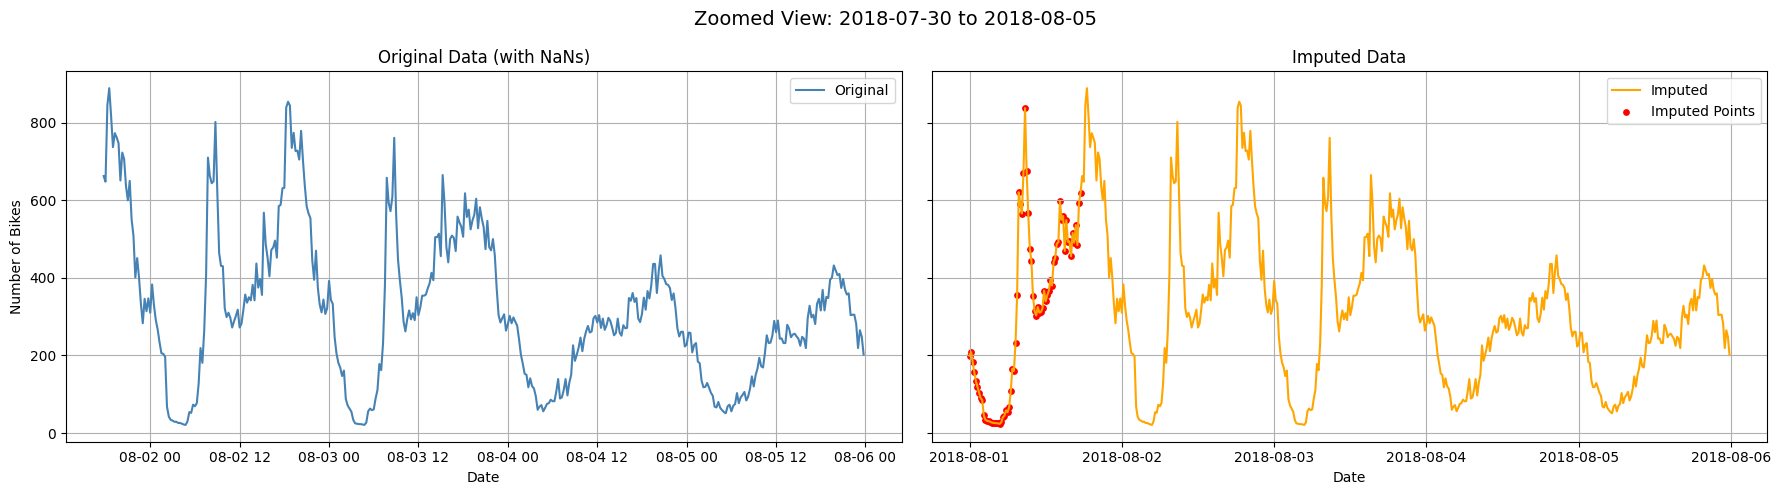

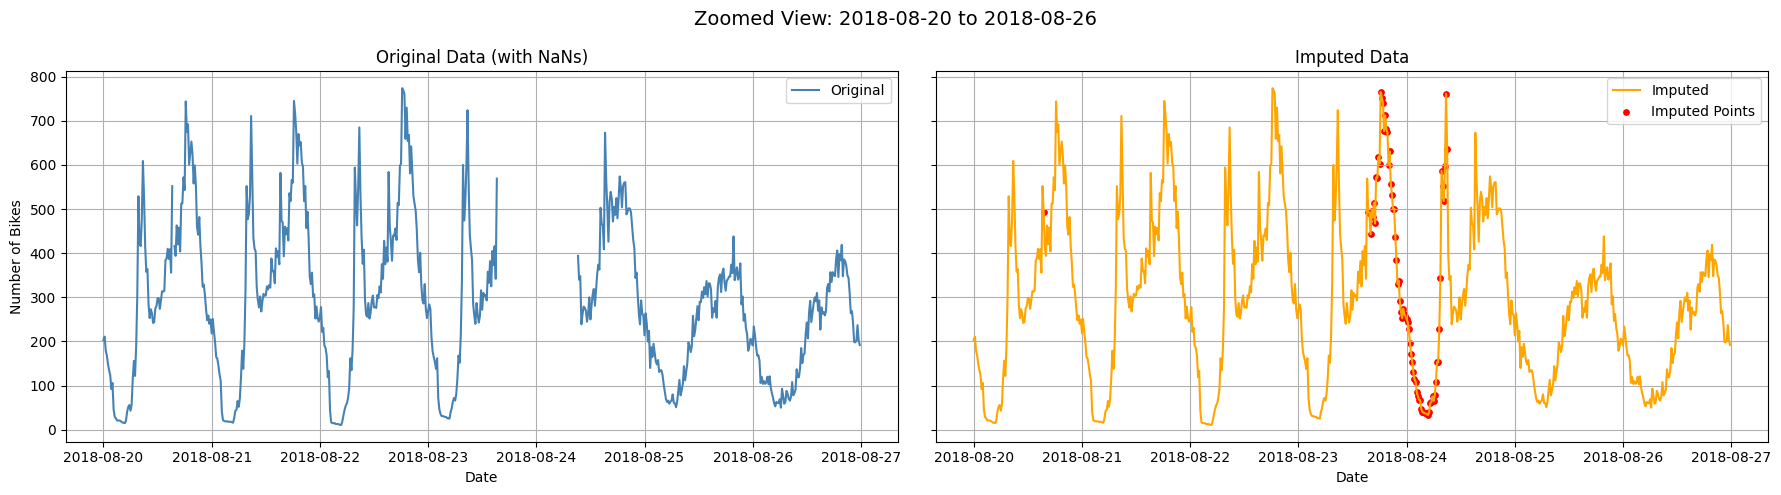

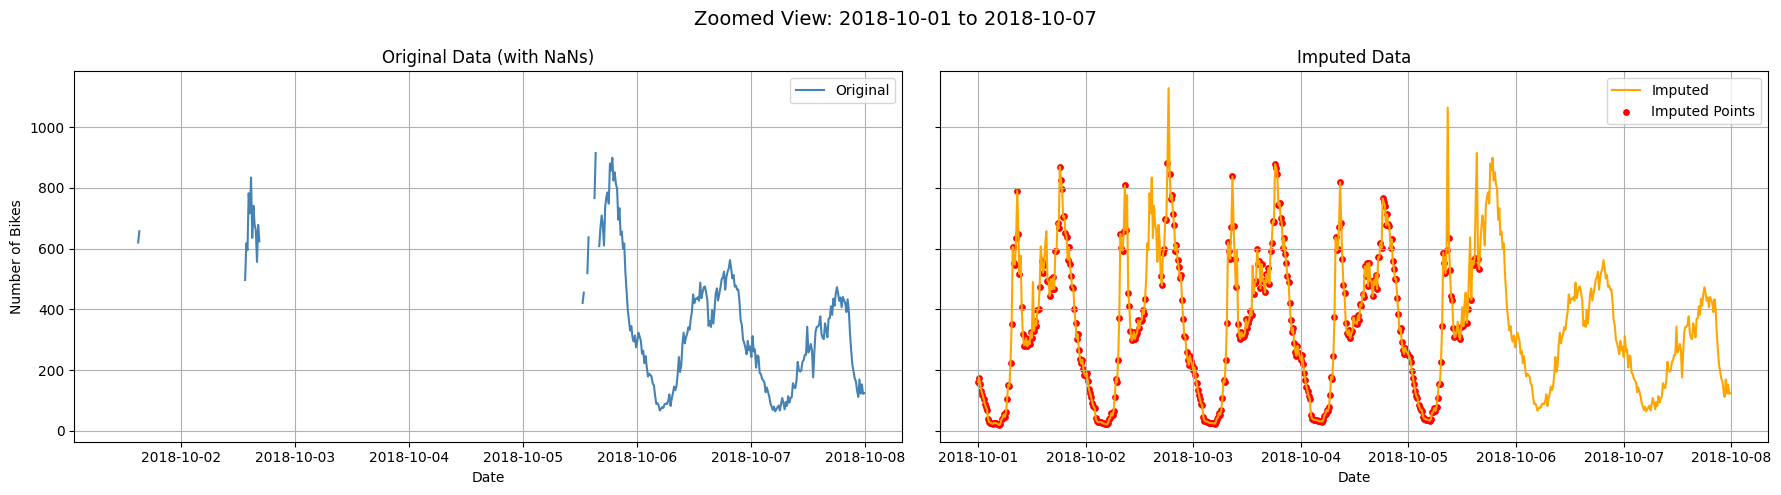

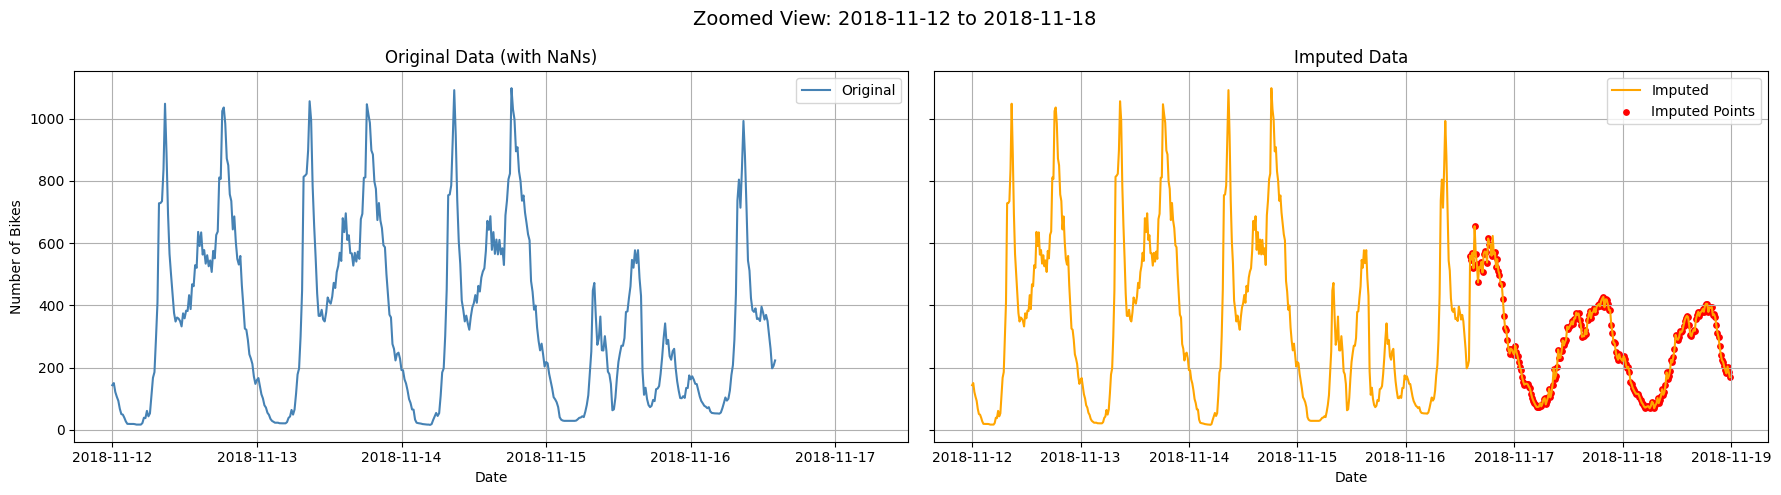

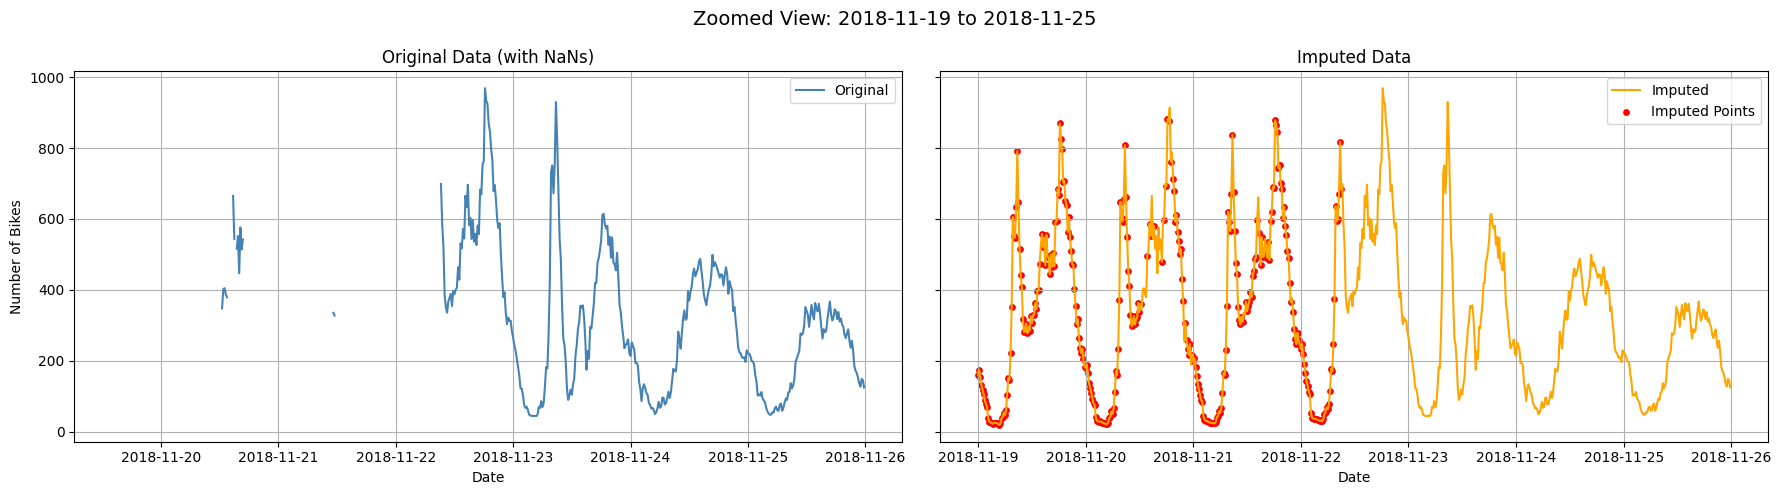

In [43]:
# Some periods to visualize the imputation

periods = [("2018-07-30", "2018-08-05"),
 ("2018-08-20", "2018-08-26"),
 ("2018-10-01", "2018-10-07"),
 ("2018-11-12", "2018-11-18"),
 ("2018-11-19", "2018-11-25")]

for period in periods:
    plot_original_vs_imputed(df_train, start_date=period[0], end_date=period[1], title_prefix="Zoomed View")

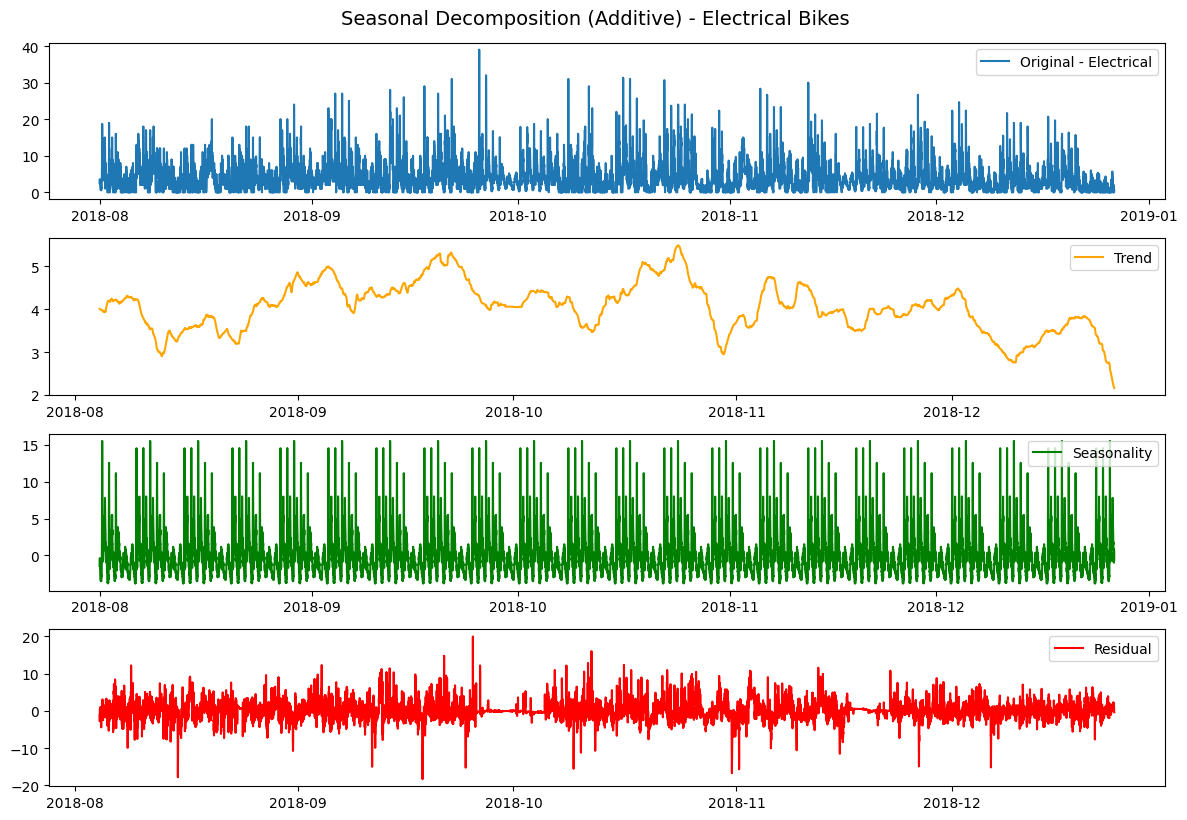

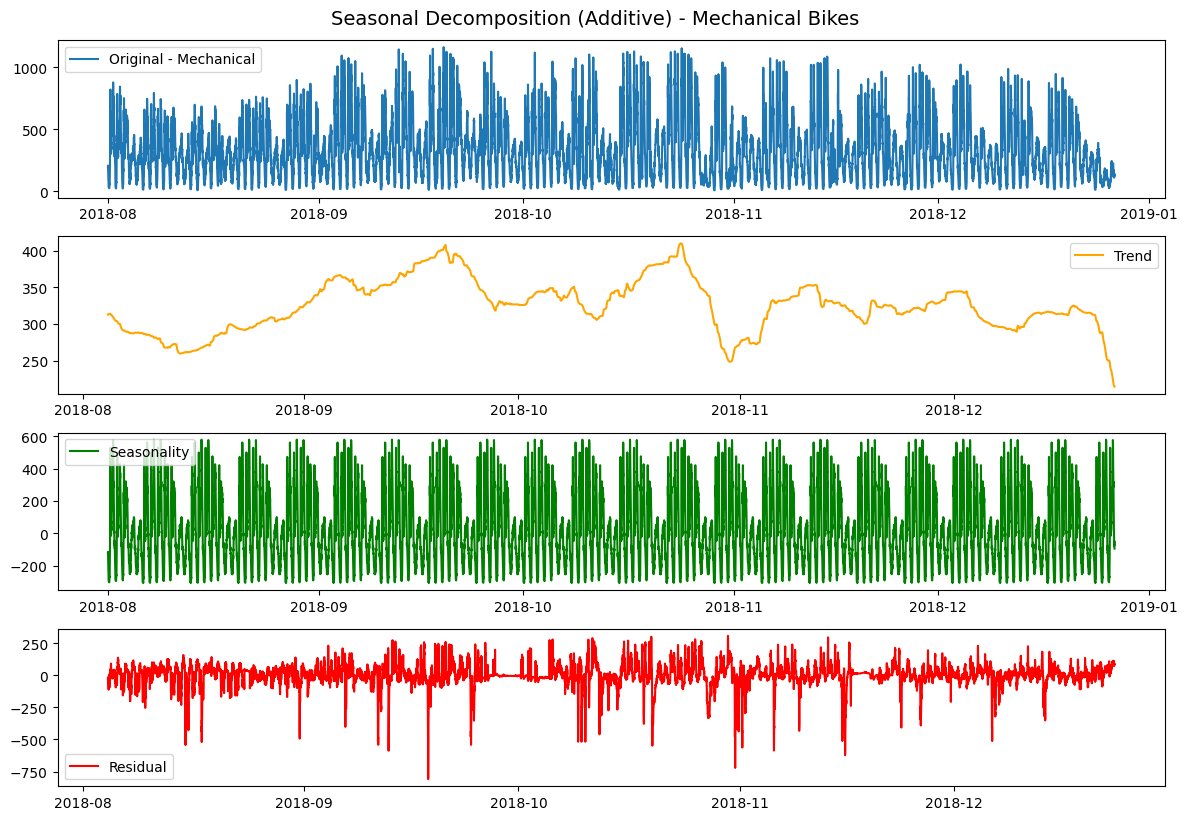

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# For electrical bikes (additive decomposition)
result_e = seasonal_decompose(df_train['electricalBikesInUsage_imputed'], model='additive', period=96*7)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result_e.observed, label='Original - Electrical')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(result_e.trend, label='Trend', color='orange')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(result_e.seasonal, label='Seasonality', color='green')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(result_e.resid, label='Residual', color='red')
plt.legend()
plt.tight_layout()
plt.suptitle("Seasonal Decomposition (Additive) - Electrical Bikes", fontsize=14, y=1.02)
plt.show()

# For mechanical bikes (additive decomposition)
result_m = seasonal_decompose(df_train['mechanicalBikesInUsage_imputed'], model='additive', period=96*7)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result_m.observed, label='Original - Mechanical')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(result_m.trend, label='Trend', color='orange')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(result_m.seasonal, label='Seasonality', color='green')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(result_m.resid, label='Residual', color='red')
plt.legend()
plt.tight_layout()
plt.suptitle("Seasonal Decomposition (Additive) - Mechanical Bikes", fontsize=14, y=1.02)
plt.show()

## Model

Nothing that I tried got a good MAPE on test set. Maybe we should simply use whole dataset and make 1 easy week forward prediction.